Modify the scratch code of gaussian mixture clustering in our lecture:
- Modify so it performs early stopping when the log likelihood does not improve anymore.  Note that if you log the normal distribution, you will get negative sign.  Thus if you ignore the negative sign, it will become negative likelihood, and thus will get smaller and smaller.
- Perform plotting every 5 iterations on the resulting clusters.

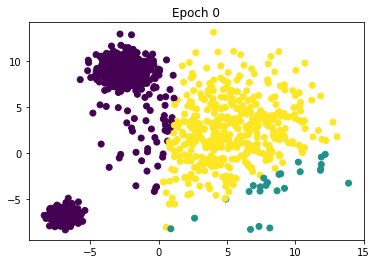

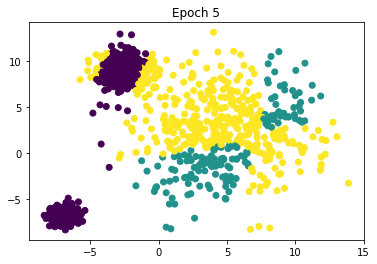

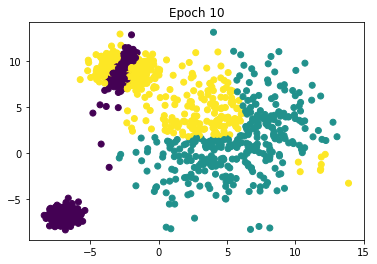

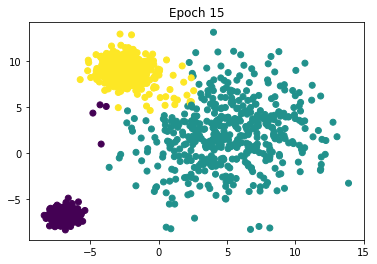

Text(0.5, 1.0, 'Final')

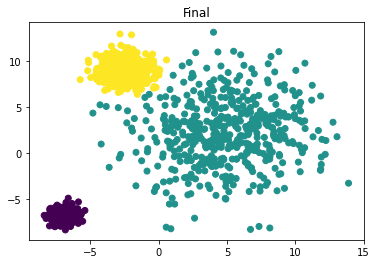

In [1]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import math

from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1500, cluster_std=[1.0, 3.5, 0.5], random_state=42)

#define basic params
m, n = X.shape
K = 3
max_iter = 20

#==initialization==

#responsibliity
r = np.full(shape=(m, K), fill_value=1/K)

#pi
pi = np.full((K, ), fill_value=1/K) #simply use 1/k for pi

#mean
random_row = np.random.randint(low=0, high=m, size=K)
mean = np.array([X[idx,:] for idx in random_row ]).T #.T to make to shape (M, K)

#covariance
cov = np.array([np.cov(X.T) for _ in range (K)])

last_NLL = np.inf

for iteration in range(max_iter):
    
    #===E-Step=====
    #Update r_ik of each sample
    for i in range(m):
        for k in range(K):
            xi_pdf = multivariate_normal.pdf(X[i], mean=mean[:, k], cov=cov[k])
            r[i, k] = pi[k] * xi_pdf
        r[i] /= np.sum(r[i])
    
    NLL = 0
    for i in range(m):
        for k in range(K):
            NLL += math.log(pi[k])
            NLL += multivariate_normal.logpdf(X[i], mean=mean[:, k], cov=cov[k])
    
    NLL_diff = np.abs(NLL - last_NLL)
    if NLL_diff < 10:
        print(f'Difference between last NLL and current NLL is', NLL_diff)
        print(f'Difference less than 10, will stop the iteration')
        break
    last_NLL = NLL
    
    if iteration % 5  == 0:
        ypred = np.argmax(r, axis=1)
        plt.figure()
        plt.scatter(X[:, 0], X[:, 1], c=ypred)
        plt.title(f'Epoch {iteration}')
        plt.show()
        
    #===M-Step====
    # Find NK first for latter use
    NK = np.sum(r, axis=0)
    assert NK.shape == (K, )
    
    #PI
    pi = NK / m
    assert pi.shape == (K, )
    
    #mean
    mean =  ( X.T @ r ) / NK
    assert mean.shape == (n, K)
    
    #covariance (also called Sigma)
    cov = np.zeros((K, n, n))
    for k in range(K):
        for i in range(m):
            X_mean = (X[i]-mean[:, k]).reshape(-1, 1)
            cov[k] += r[i, k] * (X_mean @ X_mean.T)
        cov[k] /= NK[k]
    assert cov.shape == (K, n, n)
        

#get preds
yhat = np.argmax(r, axis=1)

#plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=yhat)
plt.title("Final")